# Transfer learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage a working neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

<img src="https://raw.githubusercontent.com/MahdadGhasemian/ai-lab/main/colab-notebooks/images/why-use-transfer-learning.png" />

In [2]:
# Are we using a GPU?
!nvidia-smi

Sun Sep 14 06:22:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Functions

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Plot the validation and training curves separetly
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  # How many epochs did we run for?
  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

## Downloading and becoming one with data

In [ ]:
# Get data (10% of 10 food classes from Food101)

In [10]:
# Downlaod via original link:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-09-14 07:43:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   267MB/s    in 0.6s    

2025-09-14 07:43:59 (267 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Donwload via mirorred link
!pip install gdown

import gdown

# Google Drive file ID
file_id = "1kSdKFxen5jURm0I6v9WBXciXr2uq9KDV"
url = f"https://drive.google.com/uc?id={file_id}"

# Download and save as zip
output = "10_food_classes_10_percent.zip"
gdown.download(url, output, quiet=False)

print("Download completed!")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Downloading...
From (original): https://drive.google.com/uc?id=1kSdKFxen5jURm0I6v9WBXciXr2uq9KDV
From (redirected): https://drive.google.com/uc?id=1kSdKFxen5jURm0I6v9WBXciXr2uq9KDV&confirm=t&uuid=1356d029-b4a4-40ad-9f63-bbd5ca7568ae
To: /home/jovyan/10_food_classes_10_percent.zip
100% 169M/169M [00:25<00:00, 6.65MB/s] 

Download completed!


In [11]:
# Extract the data
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [12]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [13]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
RESCALE_NUMBER = 1/255.

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=RESCALE_NUMBER)
test_datagen = ImageDataGenerator(rescale=RESCALE_NUMBER)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [14]:
# Create TensforBoard callback (functionalized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using TensorflowHub

`TensorFlow Hub` is a repository of trained machine learning models.

https://www.tensorflow.org/hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/ or https://www.kaggle.com/models?tfhub-redirect=true

Browsing the TensorFlow Hub page (kaggle.com/models/) and sorting for image classifciation, we found the following feature vector model link:
https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1

In [3]:
!pip install tf_keras --quiet

import tensorflow as tf
import keras
import tf_keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("tf_keras version:", tf_keras.__version__)


TensorFlow version: 2.19.0
Keras version: 3.10.0
tf_keras version: 2.19.0


In [8]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1"


In [4]:
# Import depndencies
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras

In [16]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  New TensforFlow Hub URL is Kaggle/models

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default to 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

  # Download the pertrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freese the already learned patters
                                           name="feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = keras.Sequential([
      feature_extractor_layer,
      keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [19]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1001)              44677609  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 44687629 (170.47 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


In [21]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])

In [29]:
# Let's fit out ResNet model to the data (10 percent of 10 classes)
import tf_keras as keras
from tf_keras.callbacks import TensorBoard
import datetime

# Create log dir
log_dir = "tensorflow_hub/resnet50V2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Proper TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[tensorboard_callback])

Epoch 1/5
24/24 [==============================] - 28s 1s/step - loss: 0.6133 - accuracy: 0.8147 - val_loss: 0.7780 - val_accuracy: 0.7440
Epoch 2/5
24/24 [==============================] - 27s 1s/step - loss: 0.4965 - accuracy: 0.8453 - val_loss: 0.7298 - val_accuracy: 0.7536
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.3763 - accuracy: 0.8947 - val_loss: 0.7279 - val_accuracy: 0.7588
Epoch 4/5
24/24 [==============================] - 37s 2s/step - loss: 0.3195 - accuracy: 0.9227 - val_loss: 0.6864 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 28s 1s/step - loss: 0.2798 - accuracy: 0.9293 - val_loss: 0.7004 - val_accuracy: 0.7672


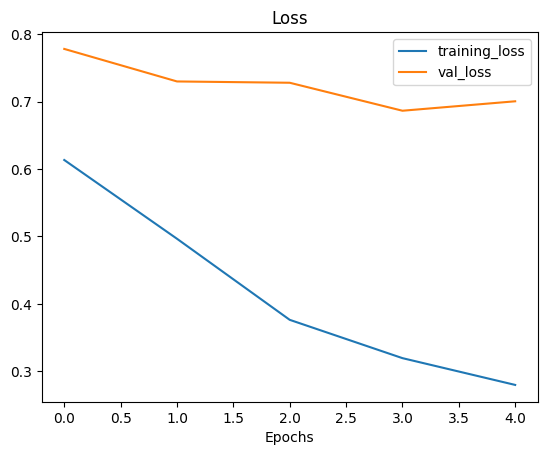

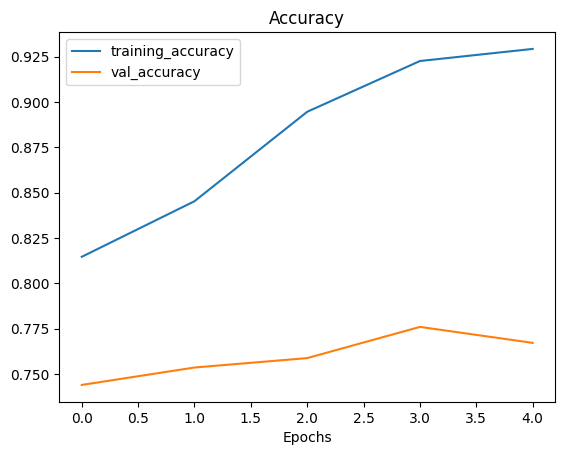

In [31]:
# Check out the model_9 loss curves
plot_loss_curves(resnet_history)